In [1]:
pip install MetaTrader5

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas numpy matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import MetaTrader5 as mt5
import pandas as pd

In [4]:

def initialize_mt5():
    path = "C:\\Program Files\\MetaTrader 5\\terminal64.exe"

    login = 116644810
    password = "ABCabc123!@#"
    server = "Exness-MT5Trial6"

    timeout = 10000
    portable = False
    if mt5.initialize(path=path, login=login, password=password, server=server, timeout=timeout, portable=portable):
        print("Initialization successful")
    else:
        print('Initialize failed')


In [5]:
initialize_mt5()

Initialization successful


In [6]:
def get_data(symbol, PREV_N_CANDLES):
    #PREV_N_CANDLES = 100
    TIME_FRAME = mt5.TIMEFRAME_M30

    rates = mt5.copy_rates_from_pos(symbol, TIME_FRAME, 0, PREV_N_CANDLES)

    ticks_frame_df = pd.DataFrame(rates)
    print(ticks_frame_df.shape)
    ticks_frame_df['time'] = pd.to_datetime(ticks_frame_df['time'], unit='s')
    return ticks_frame_df

In [7]:
# def get_data(symbol, PREV_N_CANDLES):

#     ticks_frame_df = pd.read_csv('EURUSD.csv')
#     print(ticks_frame_df.shape)
    
#     ticks_frame_df['time'] = pd.to_datetime(ticks_frame_df['time'], unit='s')
#     return ticks_frame_df

In [8]:
df = get_data('EURUSD', 100)
print(df.shape)
df.head()

(100, 8)
(100, 8)


,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-06-06 06:30:00,1.08783,1.08841,1.08769,1.08838,806,6,0
1,2024-06-06 07:00:00,1.08835,1.08878,1.08785,1.08829,949,6,0
2,2024-06-06 07:30:00,1.08829,1.08829,1.08757,1.08781,845,6,0
3,2024-06-06 08:00:00,1.08781,1.08788,1.08716,1.08749,796,6,0
4,2024-06-06 08:30:00,1.08750,1.08773,1.08710,1.08772,718,6,0


# HIDEM MARKOV MODEL

In [10]:
pip install pandas numpy hmmlearn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler

symbol = 'EURUSD'
# Load historical forex data
df = get_data(symbol, 50)

# Preprocess data: Assume 'close' prices are used
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Feature engineering: Calculate returns
df['Returns'] = df['close'].pct_change().dropna()


# Remove NaN and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Prepare data for HMM
returns = df['Returns'].values.reshape(-1, 1)

df.head()


(50, 8)


,time,open,high,low,close,tick_volume,spread,real_volume,Returns
1,2024-06-07 14:00:00,1.08192,1.08217,1.08128,0.984487,1806,6,0,-0.015513
2,2024-06-07 14:30:00,1.08180,1.08252,1.08100,0.917661,1718,6,0,-0.067879
3,2024-06-07 15:00:00,1.08122,1.08128,1.08055,0.855609,1272,6,0,-0.067620
4,2024-06-07 15:30:00,1.08069,1.08093,1.08039,0.844869,1013,6,0,-0.012552
5,2024-06-07 16:00:00,1.08061,1.08107,1.08040,0.896181,997,6,0,0.060734


E:\Users\XIAN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


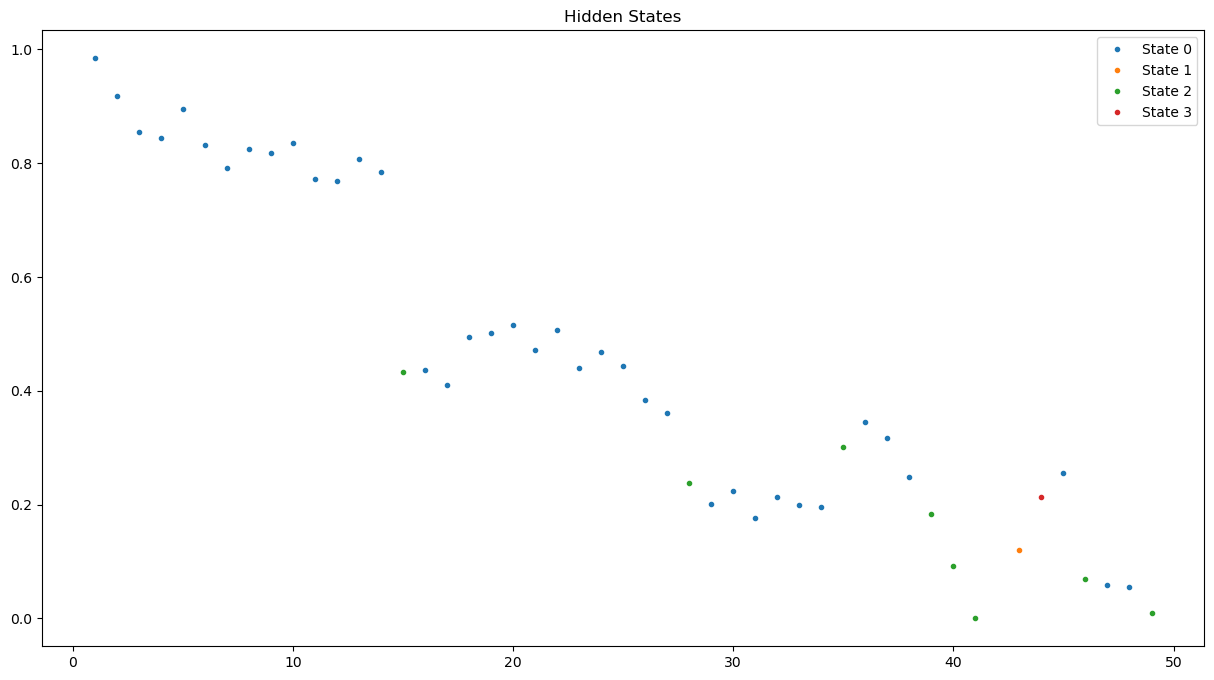

In [140]:
# Initialize and fit HMM
model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)
model.fit(returns)

# Predict hidden states
hidden_states = model.predict(returns)

# Add hidden states to the dataframe
df['Hidden State'] = hidden_states

# Visualize the hidden states
plt.figure(figsize=(15, 8))
for i in range(model.n_components):
    state = (hidden_states == i)
    plt.plot(df.index[state], df['close'][state], '.', label=f'State {i}')
plt.legend()
plt.title('Hidden States')
plt.show()


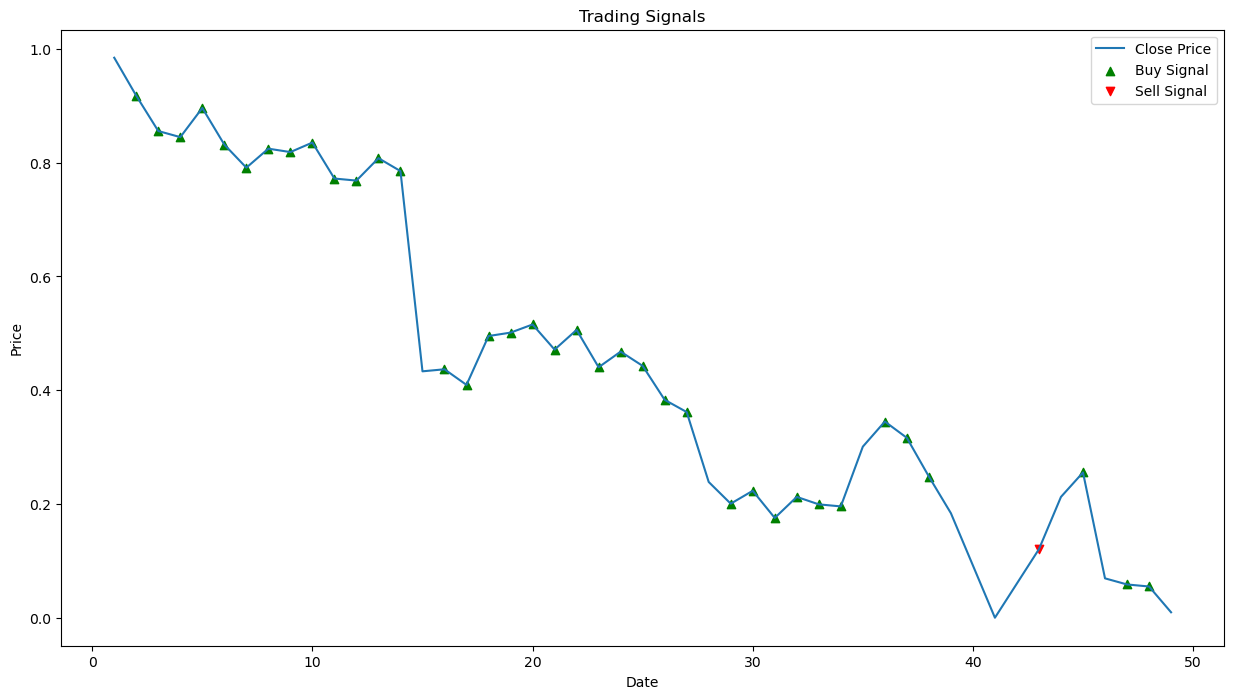

In [141]:
# Generate trading signals
signals = []
for i in range(1, len(hidden_states)):
    if hidden_states[i] == 0:
        signals.append('Buy')
    elif hidden_states[i] == 1:
        signals.append('Sell')
    else:
        signals.append('Hold')

# Add 'Hold' signal for the first entry
signals.insert(0, 'Hold')

# Add signals to the dataframe
df['Signal'] = signals

# Visualize the signals
plt.figure(figsize=(15, 8))
plt.plot(df['close'], label='Close Price')
plt.scatter(df[df['Signal'] == 'Buy'].index, df[df['Signal'] == 'Buy']['close'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Signal'] == 'Sell'].index, df[df['Signal'] == 'Sell']['close'], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Long Short-Term Memory (LSTM) Networks

In [79]:
pip install pandas numpy matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load historical forex data
df = get_data('EURUSD', 5000)

# Assume 'Close' prices are used
data = df[['close']].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for the LSTM model
lookback = 24
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Reshape data for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


(5000, 8)


Epoch 1/100
125/125 [==============================] - 4s 16ms/step - loss: 0.0177 - val_loss: 0.0012
Epoch 2/100
125/125 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
125/125 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
125/125 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 9.9989e-04
Epoch 5/100
125/125 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 7.2935e-04
Epoch 6/100
125/125 [==============================] - 1s 12ms/step - loss: 9.2275e-04 - val_loss: 7.0639e-04
Epoch 7/100
125/125 [==============================] - 1s 12ms/step - loss: 8.4628e-04 - val_loss: 6.9257e-04
Epoch 8/100
125/125 [==============================] - 1s 12ms/step - loss: 7.7208e-04 - val_loss: 7.6858e-04
Epoch 9/100
125/125 [==============================] - 1s 12ms/step - loss: 7.1838e-04 - val_loss: 5.4082e-04
Epoch 10/100
125/125 [====================

125/125 [==============================] - 1s 12ms/step - loss: 2.6816e-04 - val_loss: 2.8549e-04
Epoch 76/100
125/125 [==============================] - 1s 12ms/step - loss: 2.7681e-04 - val_loss: 1.9991e-04
Epoch 77/100
125/125 [==============================] - 1s 12ms/step - loss: 2.7481e-04 - val_loss: 2.0145e-04
Epoch 78/100
125/125 [==============================] - 1s 12ms/step - loss: 2.5590e-04 - val_loss: 2.3008e-04
Epoch 79/100
125/125 [==============================] - 1s 12ms/step - loss: 2.7219e-04 - val_loss: 1.9671e-04
Epoch 80/100
125/125 [==============================] - 1s 12ms/step - loss: 2.6480e-04 - val_loss: 1.9578e-04
Epoch 81/100
125/125 [==============================] - 1s 12ms/step - loss: 2.6488e-04 - val_loss: 1.9677e-04
Epoch 82/100
125/125 [==============================] - 1s 12ms/step - loss: 2.6701e-04 - val_loss: 2.0252e-04
Epoch 83/100
125/125 [==============================] - 1s 12ms/step - loss: 2.7493e-04 - val_loss: 2.5609e-04
Epoch 84/100
1

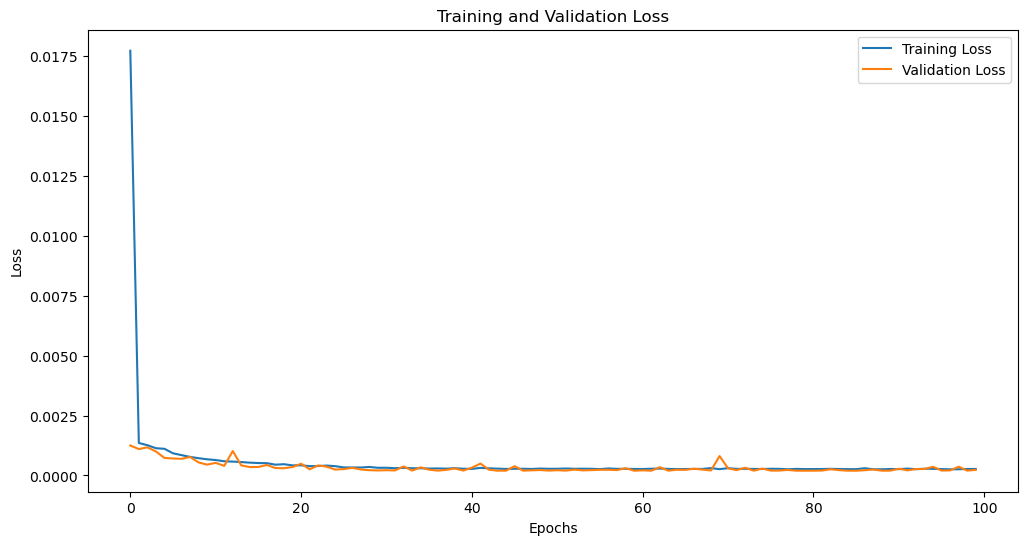

In [125]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [126]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Check conversion
print("First 5 predictions (original scale):", predictions_original[:5])
print("First 5 actual values (original scale):", y_test_original[:5])


32/32 [==============================] - 1s 4ms/step
First 5 predictions (original scale): [[1.07765  ]
 [1.0773815]
 [1.0773548]
 [1.0772607]
 [1.0771759]]
First 5 actual values (original scale): [[1.07716]
 [1.07715]
 [1.07705]
 [1.07697]
 [1.07703]]


In [127]:
# Generate trading signals using a simple rule
signals = []
for i in range(1, len(predictions_original)):
    if predictions_original[i] > y_test_original[i-1]:
        signals.append('Buy')
    elif predictions_original[i] < y_test_original[i-1]:
        signals.append('Sell')
    else:
        signals.append('Hold')

# Add 'Hold' signal for the first entry
signals.insert(0, 'Hold')

# Add signals to the dataframe
df_signals = pd.DataFrame({
    'Actual Price': y_test_original.flatten(),
    'Predicted Price': predictions_original.flatten(),
    'Signal': signals
})

# Display the dataframe with signals
print(df_signals.tail(20))


     Actual Price  Predicted Price Signal
976       1.07554         1.076791    Buy
977       1.07522         1.075800    Buy
978       1.07541         1.075437    Buy
979       1.07501         1.075606    Buy
980       1.07532         1.075229    Buy
981       1.07521         1.075486    Buy
982       1.07518         1.075400    Buy
983       1.07606         1.075362    Buy
984       1.07643         1.076210    Buy
985       1.07619         1.076622    Buy
986       1.07562         1.076402    Buy
987       1.07508         1.075848    Buy
988       1.07431         1.075323    Buy
989       1.07354         1.074577    Buy
990       1.07368         1.073811    Buy
991       1.07455         1.073891    Buy
992       1.07532         1.074705    Buy
993       1.07568         1.075471    Buy
994       1.07412         1.075838    Buy
995       1.07447         1.074349    Buy


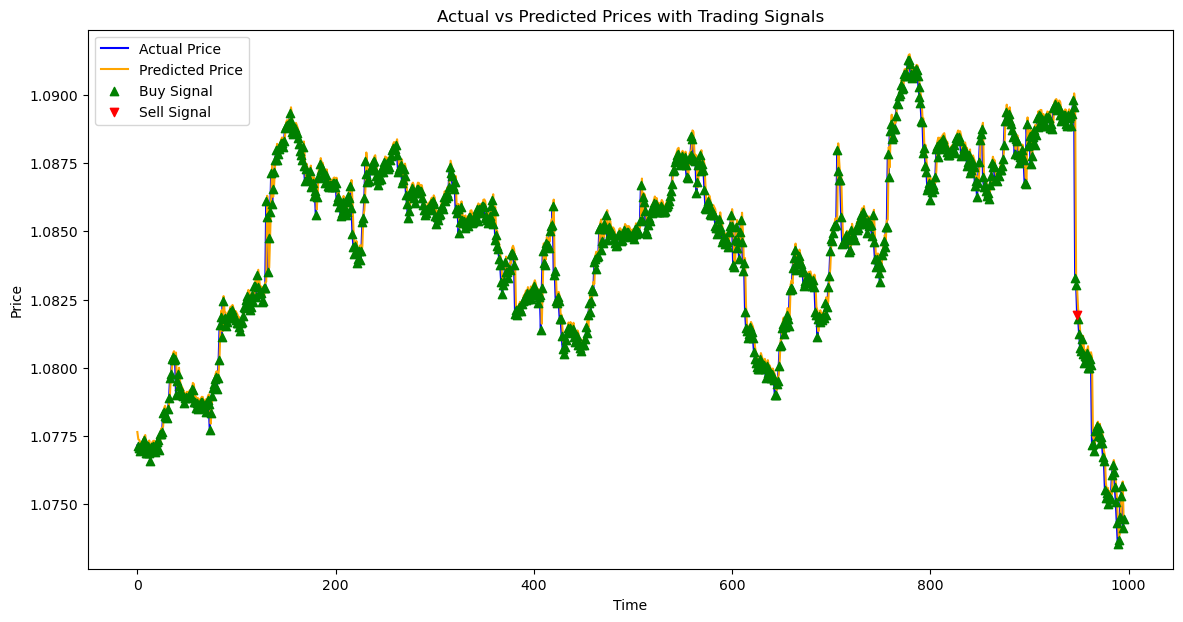

In [128]:
plt.figure(figsize=(14, 7))

plt.plot(df_signals.index, df_signals['Actual Price'], label='Actual Price', color='blue')
plt.plot(df_signals.index, df_signals['Predicted Price'], label='Predicted Price', color='orange')
plt.scatter(df_signals[df_signals['Signal'] == 'Buy'].index, df_signals[df_signals['Signal'] == 'Buy']['Actual Price'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(df_signals[df_signals['Signal'] == 'Sell'].index, df_signals[df_signals['Signal'] == 'Sell']['Actual Price'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title('Actual vs Predicted Prices with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Convolutional Neural Networks (CNNs)

In [39]:
pip install pandas numpy matplotlib tensorflow MetaTrader5


Note: you may need to restart the kernel to use updated packages.


In [129]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime


# Get historical data
df = get_data("EURUSD", 5000)

# Preprocess data
data = df[['close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for the CNN model
lookback = 20
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Reshape data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

df.head()

(5000, 8)


,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-01-16 11:00:00,1.08808,1.08875,1.08736,1.08875,1295,6,0
1,2024-01-16 11:30:00,1.08874,1.08945,1.08866,1.08920,1271,6,0
2,2024-01-16 12:00:00,1.08920,1.08931,1.08867,1.08899,1238,6,0
3,2024-01-16 12:30:00,1.08899,1.08923,1.08835,1.08859,1316,6,0
4,2024-01-16 13:00:00,1.08860,1.08881,1.08743,1.08774,1773,6,0


Epoch 1/100
125/125 [==============================] - 1s 2ms/step - loss: 0.0220 - val_loss: 0.0016
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0014
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 9.6348e-04
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 9.0646e-04
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 5.5299e-04
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 5.6446e-04
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss:

125/125 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 2.5352e-04
Epoch 79/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 2.6710e-04
Epoch 80/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 2.7296e-04
Epoch 81/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 2.4998e-04
Epoch 82/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 3.9755e-04
Epoch 83/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 3.8180e-04
Epoch 84/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 2.4439e-04
Epoch 85/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 2.7760e-04
Epoch 86/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 3.0255e-04
Epoch 87/100
125/125 [==============================] - 0s 

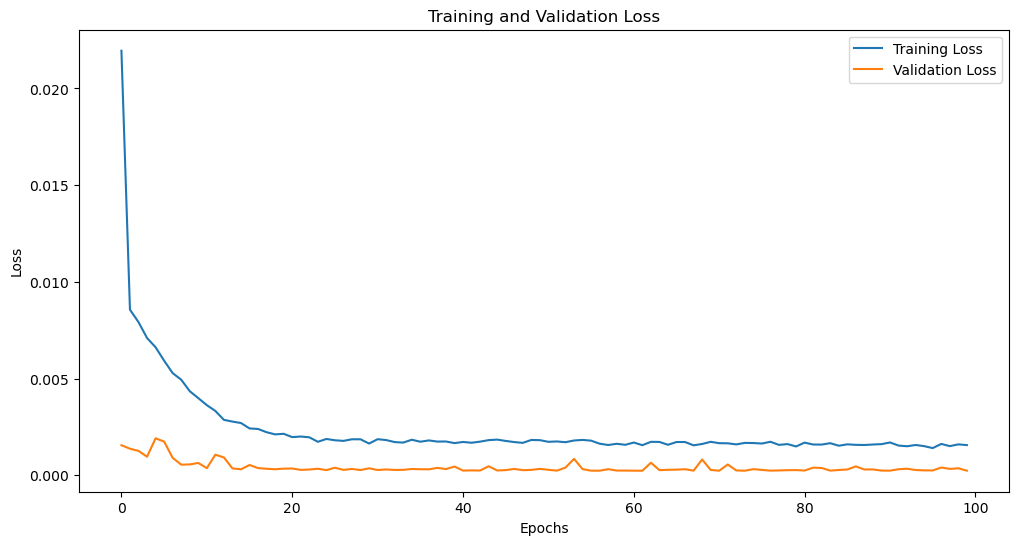

In [130]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(lookback, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [131]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions_original = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Check conversion
print("First 5 predictions (original scale):", predictions_original[:5])
print("First 5 actual values (original scale):", y_test_original[:5])


32/32 [==============================] - 0s 841us/step
First 5 predictions (original scale): [[1.0773122]
 [1.0771959]
 [1.07723  ]
 [1.0771996]
 [1.0771612]]
First 5 actual values (original scale): [[1.07715]
 [1.07705]
 [1.07697]
 [1.07703]
 [1.07712]]


In [132]:
# Generate trading signals using a simple rule
signals = []
for i in range(1, len(predictions_original)):
    if predictions_original[i] > y_test_original[i-1]:
        signals.append('Buy')
    elif predictions_original[i] < y_test_original[i-1]:
        signals.append('Sell')
    else:
        signals.append('Hold')

# Add 'Hold' signal for the first entry
signals.insert(0, 'Hold')

# Add signals to the dataframe
df_signals = pd.DataFrame({
    'Actual Price': y_test_original.flatten(),
    'Predicted Price': predictions_original.flatten(),
    'Signal': signals
})

# Display the dataframe with signals
print(df_signals.tail(20))


     Actual Price  Predicted Price Signal
976       1.07522         1.076293    Buy
977       1.07541         1.075622    Buy
978       1.07501         1.075742    Buy
979       1.07532         1.075519    Buy
980       1.07521         1.075552    Buy
981       1.07518         1.075559    Buy
982       1.07606         1.075450    Buy
983       1.07643         1.076008   Sell
984       1.07619         1.076635    Buy
985       1.07562         1.076525    Buy
986       1.07508         1.076030    Buy
987       1.07431         1.075533    Buy
988       1.07354         1.074927    Buy
989       1.07368         1.074109    Buy
990       1.07455         1.073917    Buy
991       1.07532         1.074596    Buy
992       1.07568         1.075460    Buy
993       1.07412         1.075958    Buy
994       1.07403         1.074822    Buy
995       1.07381         1.074135    Buy


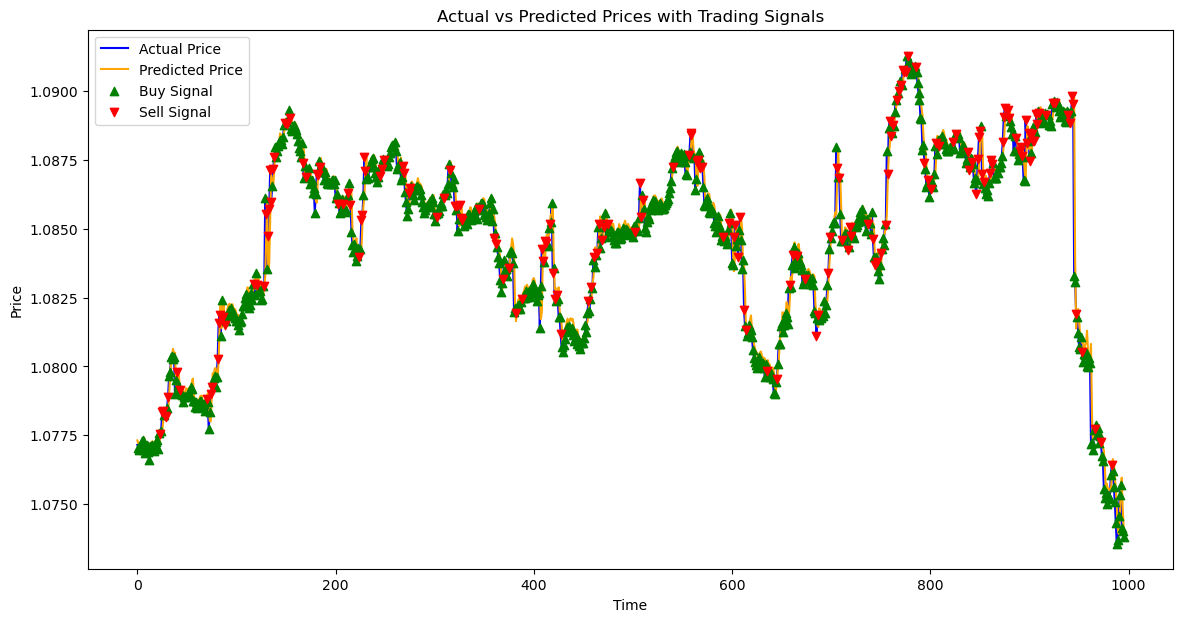

In [133]:
plt.figure(figsize=(14, 7))

plt.plot(df_signals.index, df_signals['Actual Price'], label='Actual Price', color='blue')
plt.plot(df_signals.index, df_signals['Predicted Price'], label='Predicted Price', color='orange')
plt.scatter(df_signals[df_signals['Signal'] == 'Buy'].index, df_signals[df_signals['Signal'] == 'Buy']['Actual Price'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(df_signals[df_signals['Signal'] == 'Sell'].index, df_signals[df_signals['Signal'] == 'Sell']['Actual Price'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title('Actual vs Predicted Prices with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


# Random Forests

In [134]:
pip install pandas numpy matplotlib MetaTrader5 scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [135]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

df = get_data('EURUSD', 5000)

# Preprocess data
data = df[['close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create features for the Random Forest model
lookback = 20
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


(5000, 8)


In [136]:
from sklearn.ensemble import RandomForestRegressor

# Build the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Check conversion
print("First 5 predictions (original scale):", predictions_original[:5])
print("First 5 actual values (original scale):", y_test_original[:5])


First 5 predictions (original scale): [[1.0771771]
 [1.0771646]
 [1.0771318]
 [1.0769366]
 [1.0770207]]
First 5 actual values (original scale): [[1.07715]
 [1.07705]
 [1.07697]
 [1.07703]
 [1.07712]]


In [137]:
# Generate trading signals using a simple rule
signals = []
for i in range(1, len(predictions_original)):
    if predictions_original[i] > y_test_original[i-1]:
        signals.append('Buy')
    elif predictions_original[i] < y_test_original[i-1]:
        signals.append('Sell')
    else:
        signals.append('Hold')

# Add 'Hold' signal for the first entry
signals.insert(0, 'Hold')

# Add signals to the dataframe
df_signals = pd.DataFrame({
    'Actual Price': y_test_original.flatten(),
    'Predicted Price': predictions_original.flatten(),
    'Signal': signals
})

# Display the dataframe with signals
print(df_signals.tail(20))


     Actual Price  Predicted Price Signal
976       1.07522         1.075678    Buy
977       1.07541         1.075367    Buy
978       1.07501         1.075433    Buy
979       1.07532         1.075117    Buy
980       1.07521         1.075349    Buy
981       1.07518         1.075256    Buy
982       1.07606         1.075283    Buy
983       1.07643         1.075984   Sell
984       1.07619         1.076642    Buy
985       1.07562         1.076499    Buy
986       1.07508         1.075611   Sell
987       1.07431         1.075199    Buy
988       1.07354         1.074320    Buy
989       1.07368         1.073293   Sell
990       1.07455         1.073476   Sell
991       1.07532         1.074337   Sell
992       1.07568         1.075129   Sell
993       1.07412         1.075524   Sell
994       1.07403         1.073850   Sell
995       1.07377         1.073960   Sell


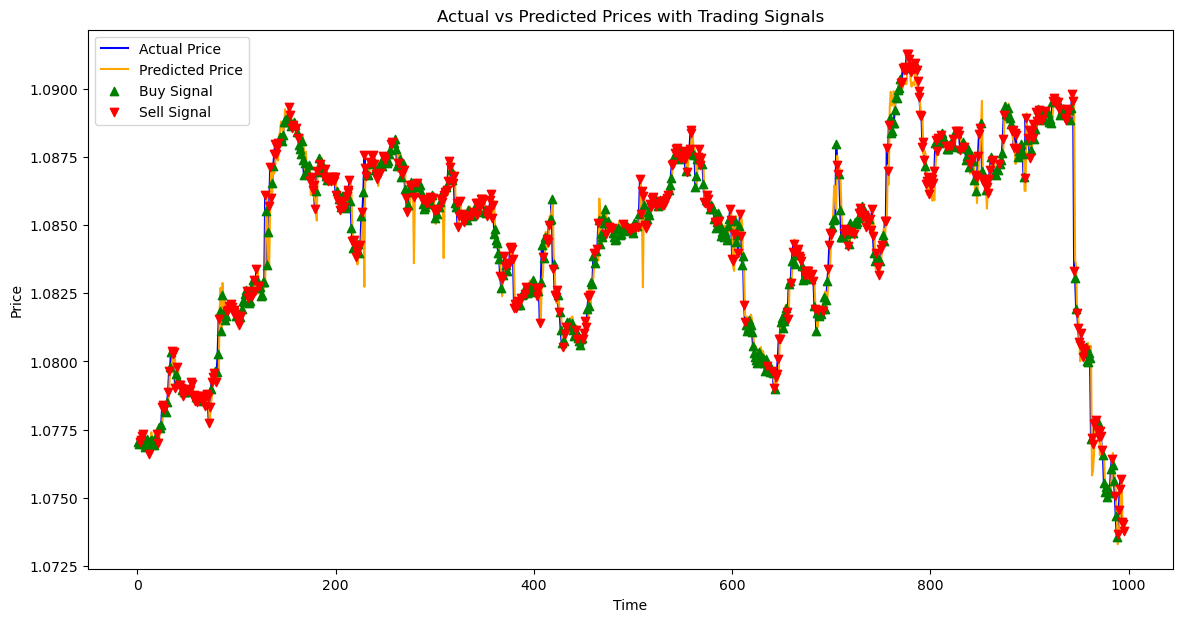

In [138]:
plt.figure(figsize=(14, 7))

plt.plot(df_signals.index, df_signals['Actual Price'], label='Actual Price', color='blue')
plt.plot(df_signals.index, df_signals['Predicted Price'], label='Predicted Price', color='orange')
plt.scatter(df_signals[df_signals['Signal'] == 'Buy'].index, df_signals[df_signals['Signal'] == 'Buy']['Actual Price'], marker='^', color='green', label='Buy Signal', zorder=5)
plt.scatter(df_signals[df_signals['Signal'] == 'Sell'].index, df_signals[df_signals['Signal'] == 'Sell']['Actual Price'], marker='v', color='red', label='Sell Signal', zorder=5)

plt.title('Actual vs Predicted Prices with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
